# Calculation of deuteron binding energy
*Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

Binding energy is the energy required to separate a system into its constituent parts. It is a measure of the stability of a system, and is the amount of energy that must be added to a system to break it apart. The concept of the binding energy has important applications in many areas of physics and chemistry, such as nuclear physics, atomic physics, and materials science. In nuclear physics, the binding energy per nucleon is used to determine the stability of atomic nuclei and to explain the phenomena of nuclear fusion and fission. In atomic physics, the binding energy is used to determine the strength of the bonds between atoms and molecules, and to explain their physical and chemical properties. In materials science, the binding energy is used to determine the strength of bonds in solids, and to design materials with specific properties for various applications.

A deuteron is a stable isotope of hydrogen with one proton and one neutron in its nucleus. It has a mass approximately equal to twice that of a hydrogen atom and is the simplest isotope of elements in the periodic table. Deuterons play a crucial role in nuclear fusion reactions and are commonly used as a target in nuclear physics experiments.

## Define deuteron Hamiltonian
The Hamiltonian used for calculation of deuteron binding energy is
$$
\begin{equation}
\hat{H}_N = \sum_{n,n^{\prime}=0}^{N-1}\langle n^{\prime}|\hat{T}+\hat{V}|n\rangle\hat{a}^{\dagger}_{n^{\prime}}\hat{a}_n
\end{equation}
$$
where $\hat{T}$ is the kinetic energy operator, $\hat{V}$ is the potential energy operator, $N$ is the dimension of the Hamiltonian. $\hat{T}$ and $\hat{V}$ can be explicitly written as
$$
\begin{align}
& \langle n^{\prime}|\hat{T}|n\rangle = \frac{\hbar\omega}{2}\left[
    (2n+3/2)\delta_{n^{\prime},n}-\sqrt{n(n+1/2)}\delta_{n^{\prime}+1,n}-\sqrt{(n+1)(n+3/2)}\delta_{n^{\prime}-1,n}
\right],\nonumber\\
& \langle n^{\prime}|\hat{V}|n\rangle = V_0\delta_{0,n}\delta_{n^{\prime},n},\nonumber
\end{align}
$$
where $\hat{a}^{\dagger}_n$ is the creation operator and $\hat{a}_n$ is the annihilation operator. Binding energy is the ground state energy of this Hamiltonian when $N\to\infty$ (We can obtain the binding energy by first calculating ground state energies when $N=1,2,3$, and then extrapolating to $N=\infty$).

To build this Hamiltonian in Paddle Quantum, we set $\hbar\omega=7\text{Mev}$ and $V_0=−5.68658111\text{Mev}$ \[1\].


In [14]:
from utils import DeuteronHamiltonian

omega = 7
V0 = -5.68658111
hamiltonian = DeuteronHamiltonian(omega, V0)

# N=2
deut_h_2 = hamiltonian.get_hamiltonian(2)
print("H2=", deut_h_2, "\n")                                 # H_2 = 5.906709I + 0.218291Z0 − 6.125Z1 - 2.143304 (X0X1 + Y0Y1)

# N=3
deut_h_3 = hamiltonian.get_hamiltonian(3)
print("H3=", deut_h_3)                                 # H_3 = H_2 + 9.625(I − Z2) − 3.913119 (X1X2 + Y1Y2)

H2= 5.906709445000001 I
0.21829055499999983 Z0
-2.1433035249352805 X0, X1
-2.1433035249352805 Y0, Y1
-6.125 Z1 

H3= 15.531709445 I
0.21829055499999983 Z0
-2.1433035249352805 X0, X1
-2.1433035249352805 Y0, Y1
-6.125 Z1
-3.913118960624632 X1, X2
-3.913118960624632 Y1, Y2
-9.625 Z2


> **NOTE**: In this tutorial, in order to encode the Hamiltonian on a quantum computer, we use Jordan-Wigner transformation \[2\] to transform creation and annihilation operators into Pauli basis.

## Build the variational quantum circuit
We use variational quantum algorithm to calculate the ground state energy of $\hat{H}_2$ and $\hat{H}_3$, and we choose unitary coupled cluster (UCC) ansatz as our variational quantum circuit. Since NISQ quantum hardware is better at handling shallow circuit, we use problem specific constraints to simplify the original UCC circuit.

Quantum circuit for deuteron N=2.


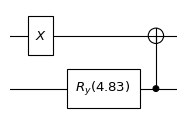

Quantum circuit for deuteron N=3.


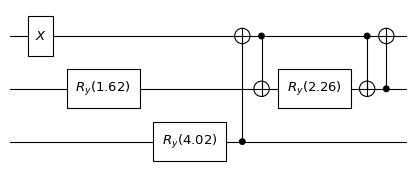

In [36]:
from utils import DeuteronUCC2, DeuteronUCC3

# Simplified UCC circuit for H_2
cir2 = DeuteronUCC2()
print("Quantum circuit for deuteron N=2.")
cir2.plot()

# Simplified UCC circuit for H_3
cir3 = DeuteronUCC3()
print("Quantum circuit for deuteron N=3.")
cir3.plot()

## Calculate ground state energy using variational quantum eigensolver (VQE)
Paddle Quantum has provided us easy-to-use `GroundStateSolver` to calculate ground state energy for a given hamiltonian, and we will use this function to calculate deuteron binding energy.

In [37]:
import paddle
from paddle.optimizer import Adam
from paddle_quantum.qchem import GroundStateSolver

paddle.seed(126)

binding_e = []
for ham, cir in [(deut_h_2, cir2), (deut_h_3, cir3)]:
    solver = GroundStateSolver(Adam, num_iterations=100, tol=1e-5)
    e, _ = solver.solve(cir, ham=ham, learning_rate=0.5)
    binding_e.append(e)

print(f"Binding energy (N=2): exact=-1.749, numerical={binding_e[0]:.5f}, relative_error={abs(binding_e[0]-(-1.749))/1.749:.5f}.")
print(f"Binding energy (N=3): exact=-2.046, numerical={binding_e[1]:.5f}, relative_error={abs(binding_e[1]-(-2.046))/2.046:.5f}.")

Binding energy (N=2): exact=-1.749, numerical=-1.74888, relative_error=0.00007.
Binding energy (N=3): exact=-2.046, numerical=-2.04526, relative_error=0.00036.


### Variation of $\hat{H}_2$ binding energy with $\theta$
Since the energy of $\hat{H}_2$ only has variational parameter $\theta$, we can plot the variation of $\langle\hat{H}_2\rangle$ with respect to $\theta$, and check that our VQE method has approached the true minimum.

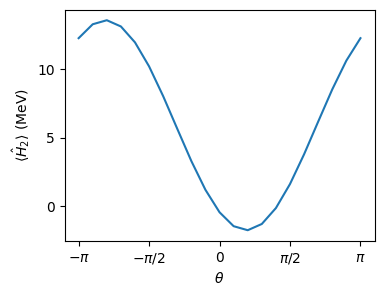

In [13]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.arange(-np.pi, 1.1*np.pi, 0.1*np.pi)
qm_expectvals = []
for theta in angles:
    cir = DeuteronUCC2(theta)
    psi = cir()
    qm_expectvals.append(psi.expec_val(deut_h_2))
print(f"The minimum value is {min(qm_expectvals):.5f}.")

fig = plt.figure(figsize=(4, 3))
ax = fig.gca()
ax.plot(angles, qm_expectvals)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\langle\hat{H}_2\rangle$ (MeV)")
ax.set_xticks([-np.pi, -np.pi/2, 0.0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax.set_yticks([0, 5, 10], ["0", "5", "10"])
plt.show()

## Reference
\[1\] Dumitrescu E F, McCaskey A J, Hagen G, et al. Cloud quantum computing of an atomic nucleus[J]. Physical review letters, 2018, 120(21): 210501

\[2\] [Jordan-Wigner transform](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation)